kWh saved / degree-hour compromised

In [82]:
import pandas as pd
import os

column_name = ['Building type name',
               'Insulation',
               'Thermal Mass'
               #'Weather Location'
               #'Baseline EnergyPlus Heating [kWh/m2/a]', #from htm
               #'Baseline EnergyPlus too warm % time > 25C', #from out csv
               #'Baseline EnergyPlus too cold % time < 20C']
]

base_path = r"W:\Insync\GDrive\Main\TU Delft\Thesis\DRL runs 11"
# EPBaseline', 'RLBaseNoForesight', 'RL24hAllRNN', 'RL24hNoSolarRNN', 'RL04hAllRNN', 'RL04hNoSolarRNN', 'RL04hFlatInput'
control_types_list = ['EPBaseline', 'RL24hAllRNN', 'RL04hAllRNN', 'RLBaseNoForesight', 'RL24hNoSolarRNN', 'RL04hNoSolarRNN', 'RL04hFlatInput']

control_pretty_names_list = ['Baseline EnergyPlus simple schedule', 'RL 24h Foresight RNN', 'RL 4h Foresight RNN', 'RL No Foresight', 'RL 24h Foresight RNN w/o Solar', 'RL 4h Foresight RNN w/o Solar', 'RL 4h Foresight flat inputs']
control_pretty_names_list = control_pretty_names_list[0:len(control_types_list)]

saving_kwh_deg_cold = [] # [Base, rl24, rl04], [ ] repeat
saving_kwh_deg_hot = [] # [Base, rl24, rl04], [ ] repeat

# week_num = 44

for i in range(52):
    week_num = i  +1

    day_range = (7 * (week_num -1) + 1, 7 * week_num)
    day_range_hours = (7 * (week_num -1) *24, 7 * week_num *24 -1)

    use_full_year = False
    if use_full_year:
        day_range_hours = (0,8760)

    print(day_range)
    print(day_range_hours)

    for name in control_pretty_names_list:
        column_name.append(f'{name} Heating [kWh/m2/a]')
        column_name.append(f'{name} too cold % time < 20C')
        column_name.append(f'{name} too warm % time > 25C')


    building_types_list = [ #'Building-InsuBASE-MassBASE']#,
                            # 'Building-InsuBASE-MassDW',
                            # 'Building-InsuBASE-MassUP',
                            # 'Building-InsuDW-MassBASE']#,
                            # 'Building-InsuDW-MassDW',
                            # 'Building-InsuDW-MassUP',
                            # 'Building-InsuUP-MassBASE']#,
                            # 'Building-InsuUP-MassDW',
                            'Building-InsuUP-MassUP']


    building_area_m2 = 2480

    rows_combined = []
    for builidng_no, unique_building_name in enumerate(building_types_list):
        
        row_in_saving_kwh_deg_cold = []
        row_in_saving_kwh_deg_hot = []

        row_in_df = []
        row_in_df.append(unique_building_name)

        if unique_building_name[13] == 'B':
            row_in_df.append('Baseline')
        elif unique_building_name[13] == 'D':
            row_in_df.append('Decreased 50%')
        elif unique_building_name[13] == 'U':
            row_in_df.append('Increased 2x')
        
        if unique_building_name[-1] == 'E':
            row_in_df.append('Baseline')
        elif unique_building_name[-1] == 'W':
            row_in_df.append('Decreased 50%')
        elif unique_building_name[-1] == 'P':
            row_in_df.append('Increased 2x')
        
        base_meter_path = os.path.join(base_path, unique_building_name, 'EPBaseline', 'out', 'eplusmtr.csv')
        base_dfmeter = pd.read_csv(base_meter_path)
        base_heat_GJ_total = base_dfmeter['DistrictHeating:Facility [J](TimeStep)'][day_range_hours[0]:day_range_hours[1]].sum() / 1_000_000_000
        base_heat_kWh_m2 = base_heat_GJ_total * 277.8 / building_area_m2

        base_epluscsv_path = os.path.join(base_path, unique_building_name, 'EPBaseline', 'out', 'eplusout.csv')
        base_epluscsv = pd.read_csv(base_epluscsv_path)

        dates = pd.date_range('2007-01-01', periods=8760, freq='H')
        s = pd.Series(dates)
        base_epluscsv['Date/Time'] = s

        base_degree_hours_cold = (20 - base_epluscsv[(base_epluscsv['Z1_GROUND_FLOOR:Zone Operative Temperature [C](Hourly)'] < 20) &
        (base_epluscsv['Date/Time'].dt.dayofweek < 5) &
        (base_epluscsv['Date/Time'].dt.hour.between(8, 15, inclusive='both')) &
        (base_epluscsv.index >= day_range_hours[0]) &
        (base_epluscsv.index <= day_range_hours[1])
        ]['Z1_GROUND_FLOOR:Zone Operative Temperature [C](Hourly)']).sum()

        for control_no, unique_control in enumerate(control_types_list):
            htm_path = os.path.join(base_path, unique_building_name, unique_control, 'out', 'eplustbl.htm')
            epluscsv_path = os.path.join(base_path, unique_building_name, unique_control, 'out', 'eplusout.csv')
            meter_path = os.path.join(base_path, unique_building_name, unique_control, 'out', 'eplusmtr.csv')

            dfmeter = pd.read_csv(meter_path)
            heat_GJ_total = dfmeter['DistrictHeating:Facility [J](TimeStep)'][day_range_hours[0]:day_range_hours[1]].sum() / 1_000_000_000

            # htm_file = pd.read_html(htm_path)
            # assert htm_file[4][13][0] == 'District Heating [GJ]', 'Wrong column/table from .HTM file'
            # heat_GJ_total = float(htm_file[4][13][1]) #GJ total building 1 year

            heat_kWh_m2 = heat_GJ_total * 277.8 / building_area_m2

            row_in_df.append(heat_kWh_m2)
            # print(heat_kWh_m2, ' kWh/m2/a for heating')

            # CSV for temperature ranges
            epluscsv = pd.read_csv(epluscsv_path)

            if unique_control == 'EPBaseline':
                dates = pd.date_range('2007-01-01', periods=8760, freq='H')
            else:
                dates = pd.date_range('2007-01-01', periods=8760, freq='H')

            #creating pandas Series with date index
            s = pd.Series(dates)
            epluscsv['Date/Time'] = s # s.dt.dayofweek # 0-6 Mon-Sun

            # *****************

            # count_too_cold = epluscsv[(epluscsv['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)'] < 20) &
            #             (epluscsv['Date/Time'].dt.dayofweek < 5) &
            #             (epluscsv['Date/Time'].dt.hour.between(8, 15, inclusive='both')) &
            #             (epluscsv.index >= day_range_hours[0]) &
            #             (epluscsv.index <= day_range_hours[1])
            #             ].count()['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)']
            # row_in_df.append(count_too_cold)
            # # print(count_too_cold, ' days too cold')

            # count_too_warm = epluscsv[(epluscsv['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)'] > 25) &
            #             (epluscsv['Date/Time'].dt.dayofweek < 5) &
            #             (epluscsv['Date/Time'].dt.hour.between(8, 15, inclusive='both')) &
            #             (epluscsv.index >= day_range_hours[0]) &
            #             (epluscsv.index <= day_range_hours[1])
            #             ].count()['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)']
            # row_in_df.append(count_too_warm)
            # # print(count_too_warm, ' days too warm')

            # *****************

            degree_hours_cold = (20 - epluscsv[(epluscsv['Z1_GROUND_FLOOR:Zone Operative Temperature [C](Hourly)'] < 20) &
                (epluscsv['Date/Time'].dt.dayofweek < 5) &
                (epluscsv['Date/Time'].dt.hour.between(8, 15, inclusive='both')) &
                (epluscsv.index >= day_range_hours[0]) &
                (epluscsv.index <= day_range_hours[1])
                ]['Z1_GROUND_FLOOR:Zone Operative Temperature [C](Hourly)']).sum()

            # print('Degree hours cold: ', degree_hours_cold)
            row_in_df.append(degree_hours_cold)

            degree_hours_hot = (25 - epluscsv[(epluscsv['Z1_GROUND_FLOOR:Zone Operative Temperature [C](Hourly)'] > 25) &
                (epluscsv['Date/Time'].dt.dayofweek < 5) &
                (epluscsv['Date/Time'].dt.hour.between(8, 15, inclusive='both')) &
                (epluscsv.index >= day_range_hours[0]) &
                (epluscsv.index <= day_range_hours[1])
                ]['Z1_GROUND_FLOOR:Zone Operative Temperature [C](Hourly)']).sum() *-1

            # print('Degree hours hot: ', degree_hours_hot)
            row_in_df.append(degree_hours_hot)

            # *****************

            # if (base_degree_hours_cold - degree_hours_cold) != 0:
            #     sav_kwh_deg = (base_heat_kWh_m2 - heat_kWh_m2) / (base_degree_hours_cold - degree_hours_cold)
            # elif (base_degree_hours_cold - degree_hours_cold) == 0:
            #     sav_kwh_deg = (base_heat_kWh_m2 - heat_kWh_m2) / 0.001
            #     # sav_kwh_deg = 0
            # row_in_saving_kwh_deg_cold.append(sav_kwh_deg)


            sav_kwh_deg = (base_heat_kWh_m2 - heat_kWh_m2) * (base_degree_hours_cold - degree_hours_cold)
            row_in_saving_kwh_deg_cold.append(sav_kwh_deg)
            

            # if degree_hours_cold != 0:
            #     sav_kwh_deg = (base_heat_kWh_m2 - heat_kWh_m2) / degree_hours_cold
            # elif degree_hours_cold == 0:
            #     sav_kwh_deg = (base_heat_kWh_m2 - heat_kWh_m2) / 0.001
            #     # sav_kwh_deg = 0
            # row_in_saving_kwh_deg_cold.append(sav_kwh_deg)
            

            if degree_hours_hot != 0:
                sav_kwh_deg = (base_heat_kWh_m2 - heat_kWh_m2) / degree_hours_hot
            elif degree_hours_hot == 0:
                sav_kwh_deg = (base_heat_kWh_m2 - heat_kWh_m2) / 0.001
                # sav_kwh_deg = 0
            row_in_saving_kwh_deg_hot.append(sav_kwh_deg)





        saving_kwh_deg_cold.append(row_in_saving_kwh_deg_cold)
        saving_kwh_deg_hot.append(row_in_saving_kwh_deg_hot)
        rows_combined.append(row_in_df)

    # print(rows_combined)
    # print(saving_kwh_deg)
    # print(saving_kwh_deg_cold[i][1] - saving_kwh_deg_cold[i][0])


    # df = pd.DataFrame(rows_combined, columns=column_name)
    # df

(1, 7)
(0, 167)
(8, 14)
(168, 335)
(15, 21)
(336, 503)
(22, 28)
(504, 671)
(29, 35)
(672, 839)
(36, 42)
(840, 1007)
(43, 49)
(1008, 1175)
(50, 56)
(1176, 1343)
(57, 63)
(1344, 1511)
(64, 70)
(1512, 1679)
(71, 77)
(1680, 1847)
(78, 84)
(1848, 2015)
(85, 91)
(2016, 2183)
(92, 98)
(2184, 2351)
(99, 105)
(2352, 2519)
(106, 112)
(2520, 2687)
(113, 119)
(2688, 2855)
(120, 126)
(2856, 3023)
(127, 133)
(3024, 3191)
(134, 140)
(3192, 3359)
(141, 147)
(3360, 3527)
(148, 154)
(3528, 3695)
(155, 161)
(3696, 3863)
(162, 168)
(3864, 4031)
(169, 175)
(4032, 4199)
(176, 182)
(4200, 4367)
(183, 189)
(4368, 4535)
(190, 196)
(4536, 4703)
(197, 203)
(4704, 4871)
(204, 210)
(4872, 5039)
(211, 217)
(5040, 5207)
(218, 224)
(5208, 5375)
(225, 231)
(5376, 5543)
(232, 238)
(5544, 5711)
(239, 245)
(5712, 5879)
(246, 252)
(5880, 6047)
(253, 259)
(6048, 6215)
(260, 266)
(6216, 6383)
(267, 273)
(6384, 6551)
(274, 280)
(6552, 6719)
(281, 287)
(6720, 6887)
(288, 294)
(6888, 7055)
(295, 301)
(7056, 7223)
(302, 308)
(7

In [83]:
saving_df_cold = pd.DataFrame(saving_kwh_deg_cold, columns=control_types_list)
saving_df_hot = pd.DataFrame(saving_kwh_deg_hot, columns=control_types_list)
# saving_df

In [55]:
# saving_df_cold
# saving_df_cold_capped = saving_df_cold.clip(upper=10)
# saving_df_cold_capped

In [89]:
# import scipy

# sample_x = np.linspace(0, np.pi, 1000)
# >>> sample_y = np.sin(sample_x) # Creating 1,000 samples
# >>> result = scipy.integrate.trapz(sample_y, sample_x)
# >>> print(result)
saving_df_cold_capped = saving_df_cold.clip(upper=1)
saving_df_cold_capped

result_list = []
result_dict = {}
for name in saving_df_cold.columns:
    result = scipy.integrate.trapz(saving_df_cold[f'{name}'], [x for x in range(saving_df_cold[f'{name}'].count())])
    result_dict[name] = result
    result_list.append(result)

dict_df = pd.DataFrame([saving_df_cold.columns, result_list])
# result_list
dict_df.T
# print(result_dict)

,0,1
0,EPBaseline,0.0
1,RL24hAllRNN,-5.436162
2,RL04hAllRNN,-0.361287
3,RLBaseNoForesight,0.0
4,RL24hNoSolarRNN,-0.819792
5,RL04hNoSolarRNN,-0.004003
6,RL04hFlatInput,0.000137


Text(0.5, 1.0, 'Zoomed in first 15 weeks')

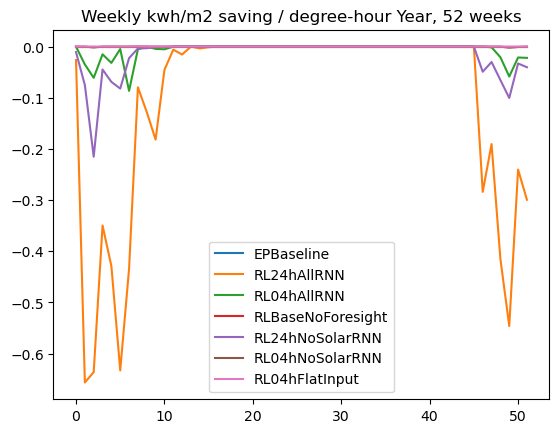

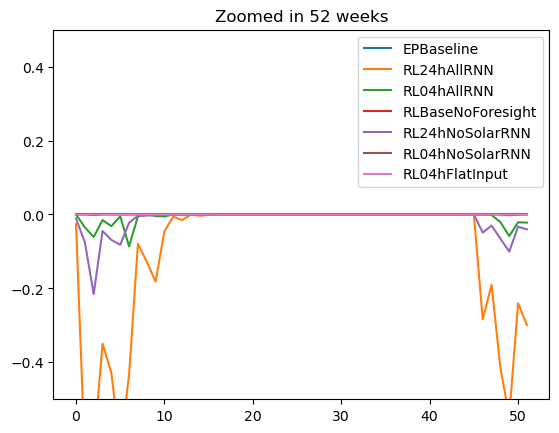

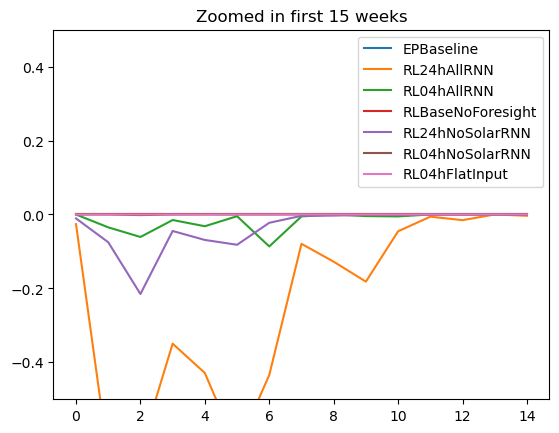

In [86]:
# saving_df[46:].plot()
saving_df_cold.plot()
# plt.ylim(top=50)
plt.title('Weekly kwh/m2 saving / degree-hour Year, 52 weeks')
# saving_df_cold[15:40].plot()
# plt.ylim(top=10)
# plt.title('graph 1 test')
saving_df_cold.plot()
plt.ylim(top=0.5, bottom=-0.5)
plt.title('Zoomed in 52 weeks')
saving_df_cold[:15].plot()
plt.ylim(top=0.5, bottom=-0.5)
plt.title('Zoomed in first 15 weeks')

# saving_df_hot.plot()
# saving_df_hot[20:35].plot()
# plt.ylim(top=10)

# Baseline Z1

<Axes: >

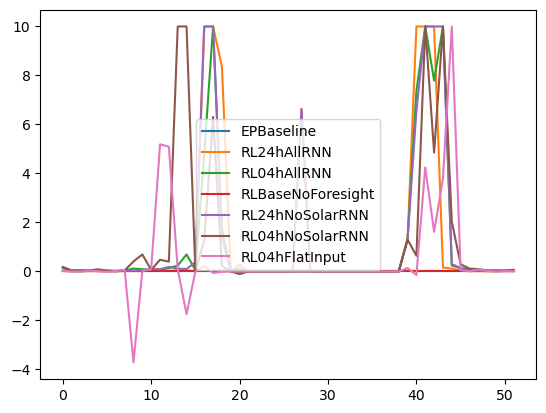

In [23]:
saving_df_cold_capped.plot()

<Axes: >

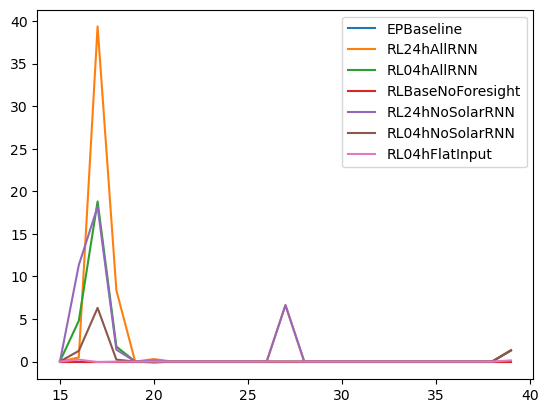

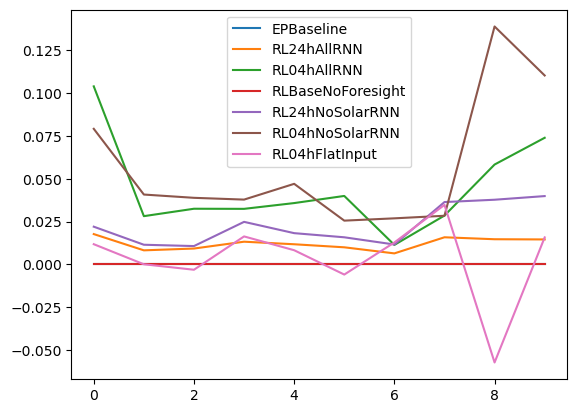

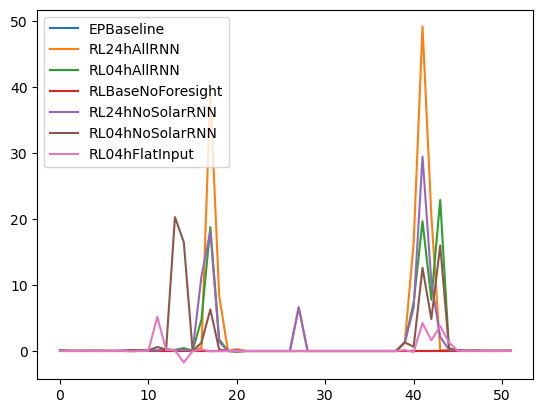

In [ ]:
# saving_df[46:].plot()
saving_df_cold[15:40].plot()
saving_df_cold[0:10].plot()
saving_df_cold.plot()
# saving_df_hot.plot()
# saving_df_hot[20:35].plot()
# plt.ylim(top=10)

# Baseline Z2

<Axes: >

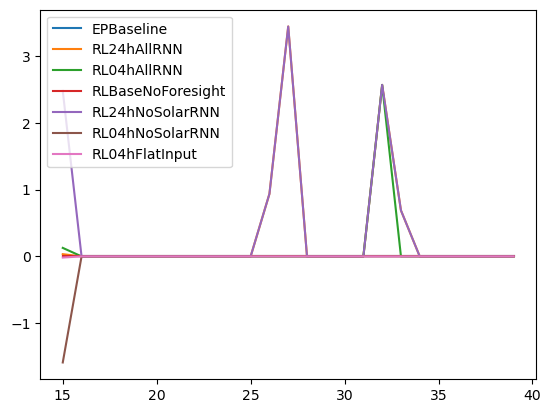

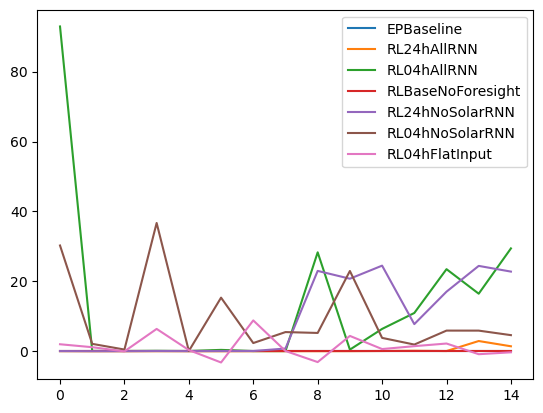

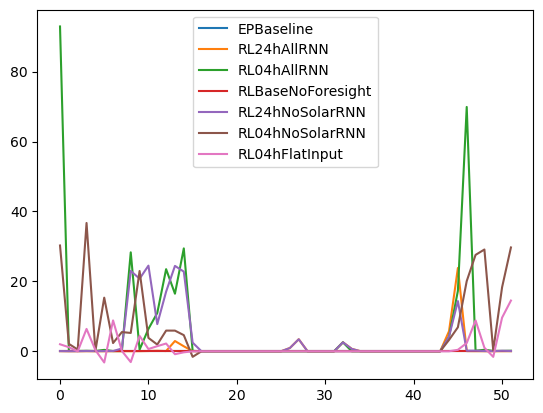

In [ ]:
# saving_df[46:].plot()
saving_df_cold[15:40].plot()
saving_df_cold[0:15].plot()
saving_df_cold.plot()
# saving_df_hot.plot()
# saving_df_hot[20:35].plot()
# plt.ylim(top=10)

# high-insulation

<Axes: >

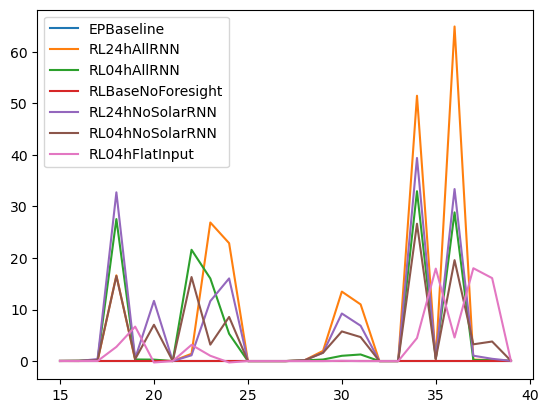

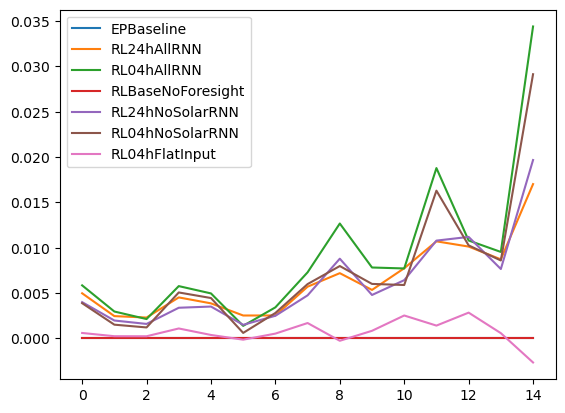

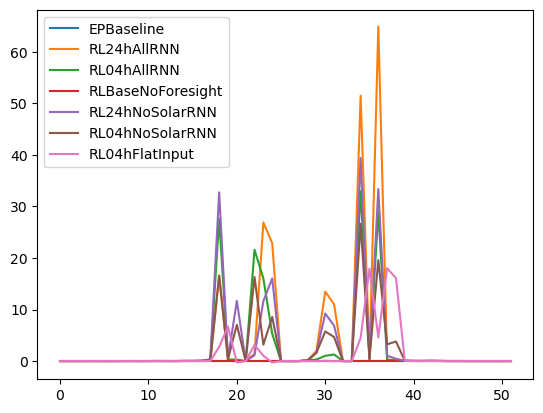

In [ ]:
# saving_df[46:].plot()
saving_df_cold[15:40].plot()
saving_df_cold[0:15].plot()
saving_df_cold.plot()
# saving_df_hot.plot()
# saving_df_hot[20:35].plot()
# plt.ylim(top=10)

# low insulation